# Getting Started with Snowflake Notebooks 

Welcome to the 2026 EY Data & AI Challenge! This notebook will get you up and running with Snowflake Notebooks.

By the end, you'll see how Snowflake can help you leverage a powerful cloud-computing environment to gather satellite imagery data to conduct geospatial analysis.

### Context

The objective of this challenge is to develop a robust machine learning model capable of predicting water quality across various river locations in South Africa. In addition to accurate predictions, the model should also identify and emphasize the key factors that significantly influence water quality.



**EXTERNAL ACCESS INTEGRATION**

You can create secure access to specific network locations external to Snowflake with an [External Access Integration](https://docs.snowflake.com/en/developer-guide/external-network-access/external-network-access-overview). 

This script creates external network access to install PyPI packages
and access Planetary Computer API endpoints. 
Note that network rules are stored in a database, while network policies 
are account-level objects that do not require a database. You can attach many
rules to the same policy.

In [ ]:
USE ROLE ACCOUNTADMIN;
USE DATABASE SNOWFLAKE_LEARNING_DB;
SET schema_name = CONCAT(current_user(), '_GETTING_STARTED_DATA_CHALLENGE');
CREATE SCHEMA IF NOT EXISTS IDENTIFIER($schema_name);
USE SCHEMA IDENTIFIER($schema_name);

CREATE SCHEMA IF NOT EXISTS SNOWFLAKE_LEARNING_DB.CORE_POLICY;
CREATE NETWORK RULE IF NOT EXISTS SNOWFLAKE_LEARNING_DB.CORE_POLICY.PLANETARY_COMPUTER_NETWORK_RULE
  MODE = EGRESS
  TYPE = HOST_PORT
  VALUE_LIST = (
    -- Primary API endpoints
    'planetarycomputer.microsoft.com',
    'api.planetarycomputer.microsoft.com',
    'planetarycomputer.microsoft.com:443',
    
    -- STAC specification endpoints
    'api.stacspec.org',
    'stacspec.org',
    
    -- Azure Blob Storage (needed for data access)
    'planetarycomputer.blob.core.windows.net',
    'cpdataeuwest.blob.core.windows.net',
    'ai4edataeuwest.blob.core.windows.net',
    'naipeuwest.blob.core.windows.net',
    
    -- Azure Data Lake Storage (for Zarr access)
    'planetarycomputer.dfs.core.windows.net',
    'cpdataeuwest.dfs.core.windows.net',
    
    -- SAS token and authentication endpoints
    '*.blob.core.windows.net',
    '*.dfs.core.windows.net',
    
    -- Microsoft authentication (if needed)
    'login.microsoftonline.com',
    'management.azure.com'
  );

CREATE OR REPLACE EXTERNAL ACCESS INTEGRATION DATA_CHALLENGE_EXTERNAL_ACCESS
  ALLOWED_NETWORK_RULES = (
    SNOWFLAKE.EXTERNAL_ACCESS.PYPI_RULE, SNOWFLAKE_LEARNING_DB.CORE_POLICY.PLANETARY_COMPUTER_NETWORK_RULE)
  ENABLED = TRUE;

-- Verify integration creation
DESCRIBE INTEGRATION DATA_CHALLENGE_EXTERNAL_ACCESS;

**Enable External Access in Notebook Settings**

Now that your External Access Integration exists, you need to give this Notebook permission to use it. 

Click the menu in the top-right of this page, and select **Notebook Settings**

Click the External Access tab at the top of the dialog box, and toggle-on **Data Challenge External Access**.

Your notebook session will automatically restart when you save.


**Import Python packages**

Snowflake Notebooks include Streamlit and the third-party packages listed in the Snowflake Anaconda channel by default. You can add any additional packages from [PyPI- Python Package Index](www.pypi.org) by loading all dependencies in your **requirements.txt** file.  You can manually upload your requirements file in the left sidebar, or you can create it manually using python.



In [ ]:
# Define your requirements
requirements = """pandas==2.2.3
pystac==1.11.0
fsspec==2024.10.0
xarray==2024.10.0
dask==2024.10.0
tqdm==4.66.5
matplotlib==3.9.2
seaborn==0.13.2
scikit-learn==1.5.2
pystac-client==0.8.5
planetary-computer==1.0.0
odc-stac==0.3.10
adlfs==2024.7.0
"""

# Write to file
with open('requirements.txt', 'w') as f:
    f.write(requirements)

# Upload to stage using Snowpark session
from snowflake.snowpark.context import get_active_session
session = get_active_session()

## Note: This notebook will be stored in a schema containing your username:
##    SNOWFLAKE_LEARNING_DB.<YOUR_USERNAME>__GETTING_STARTED_DATA_CHALLENGE
## If your notebook is in a different location, 
##    update the URL below:
session.file.put('requirements.txt', 'snow://notebook/SNOWFLAKE_LEARNING_DB.DATACHALLENGE_GETTING_STARTED_DATA_CHALLENGE.GETTING_STARTED_DATA_CHALLENGE/versions/live/', auto_compress=False, overwrite=True)
print("Uploaded to stage! Refresh browser tab to see the file in the left sidebar navigation.")

**Verify contents of requirements.txt**

When you refresh your browser tab, you should see a requirements.txt file in the left sidebar navigation.

You can click once on the file, and it will open an editable window that autosaves, so you can add additional PyPI libraries very easily. 

When you are ready, run the next cell to install all of the third-party libraries from the Snowflake PyPI Repository.


In [ ]:
!pip install -r requirements.txt

## Landsat Scene Viewer with Cloud Filtering and Phenology

This notebook calculates vegetation phenology using Landsat data with cloud filtering. This pixel-based approach is better than a scene-based approach since clouds are quite random for any given time and location. To address phenology, the algorithm uses the Normalized Difference Vegetation Index (NDVI) which is a common proxy for vegetation growth and health. The outputs of this notebook can be used to assess differences in agriculture fields over time or space and also allow the assessment of growing states such as planting and harvesting. The baseline data is [Landsat Collection 2 Level 2](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) data from the MS Planetary Computer catalog. 

In [ ]:
create or replace external access integration pypi_access
  ALLOWED_NETWORK_RULES = (snowflake.external_access.pypi_rule)
  ENABLED = true;


In [ ]:
CREATE SCHEMA IF NOT EXISTS DATA;
CREATE STAGE IF NOT EXISTS DATA.TERRACLIMATE_STAGE
    COMMENT = 'Stage for storing TerraClimate data and outputs';


In [ ]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Import Dask for chunked array support
import dask
import dask.array as da

# Import Planetary Computer tools
import pystac_client
import planetary_computer as pc
import odc
from odc.stac import stac_load

### Load the satellite data

First, we define our area of interest using latitude and longitude coordinates of the centroid. Then we define the size of the surrounding bounding box (in degrees). GeoJSON format uses a specific order: (longitude, latitude), so be careful when entering the coordinates. Finally, we define the time window consistent with a typical rice growing season.

In [2]:
# Sample Rice Crop Field in An Giang, Vietnam
# lat_long = (10.4391, 105.3338) # Lat-Lon centroid location
# box_size_deg = 0.10 # Surrounding box in degrees

# Add Brian's Location here !!!
lat_long = (37.12167, -76.48291) # Lat-Lon centroid location
box_size_deg = 0.10 # Surrounding box in degrees

In [3]:
# Calculate the Lat-Lon bounding box region
min_lon = lat_long[1]-box_size_deg/2
min_lat = lat_long[0]-box_size_deg/2
max_lon = lat_long[1]+box_size_deg/2
max_lat = lat_long[0]+box_size_deg/2
bounds = (min_lon, min_lat, max_lon, max_lat)

In [4]:
# Define the time window
# time_window="2021-12-01/2022-04-30"  # original
# time_window="2021-12-10/2022-01-28" # test #1
time_window="2025-01-01/2025-03-06" # test #2

Using the `pystac_client` we can search the Planetary Computer's STAC catalog for items matching our query parameters. The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes and may contain clouds. To avoid issues with Landsat-7 data, we have only included data from Landsat-8 and Landsat-9 missions.

In [5]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = stac.search(
    collections=["landsat-c2-l2"], 
    bbox=bounds, 
    datetime=time_window,
    query={"platform": {"in": ["landsat-8", "landsat-9"]},},
)
items = list(search.get_all_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 17


Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using the Open Data Cube (ODC) STAC [odc-stac](https://odc-stac.readthedocs.io/en/latest/index.html) library that is included with the Planetary Computer. The ODC [odc](https://www.opendatacube.org) is an open source geospatial data management and analysis software project that is used globally for many projects (e.g., Digital Earth Africa). The ODC-STAC code will load the selected items from the catalog search, select the desired spectral bands, including the "qa_pixel" cloud filtering band, reproject into Lat-Lon coordinates (EPSG:4326) at 30-meters resolution (typical of Landsat pixel resolution), and clip the region to the spatial bounding box. 

In [6]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 30  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for CRS:4326 

In [7]:
xx = stac_load(
    items,
    bands=["red", "green", "blue", "nir08", "qa_pixel"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    patch_url=pc.sign,
    bbox=bounds
)

In [8]:
# Apply scaling and offsets for Landsat Collection-2 (reference below) to the spectral bands ONLY
# https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2
xx['red'] = (xx['red']*0.0000275)-0.2
xx['green'] = (xx['green']*0.0000275)-0.2
xx['blue'] = (xx['blue']*0.0000275)-0.2
xx['nir08'] = (xx['nir08']*0.0000275)-0.2

In [9]:
# View the dimensions of our XARRAY and the variables
display(xx)

<xarray.Dataset> Size: 80MB
Dimensions:      (latitude: 372, longitude: 372, time: 17)
Coordinates:
  * latitude     (latitude) float64 3kB 37.17 37.17 37.17 ... 37.07 37.07 37.07
  * longitude    (longitude) float64 3kB -76.53 -76.53 -76.53 ... -76.43 -76.43
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 136B 2025-01-01T15:40:45.914305 ... 20...
Data variables:
    red          (time, latitude, longitude) float64 19MB dask.array<chunksize=(1, 372, 372), meta=np.ndarray>
    green        (time, latitude, longitude) float64 19MB dask.array<chunksize=(1, 372, 372), meta=np.ndarray>
    blue         (time, latitude, longitude) float64 19MB dask.array<chunksize=(1, 372, 372), meta=np.ndarray>
    nir08        (time, latitude, longitude) float64 19MB dask.array<chunksize=(1, 372, 372), meta=np.ndarray>
    qa_pixel     (time, latitude, longitude) uint16 5MB dask.array<chunksize=(1, 372, 372), meta=np.ndarray>

### View RGB (real color) images from the time series

Data is available for Landsat-8 from April-2013 to now. Data is available for Landsat-9 from Feb-2022 to now. So, for the selected time window and missions there are typically views of our region every 8 days. But, due to scene overlaps, there are few more scenes within those 8-day increments. For this example over 5 months, there are 31 time slices that touch our region. Unfortunately, there are only 7 very clear scenes and several other partially cloudy scenes. 

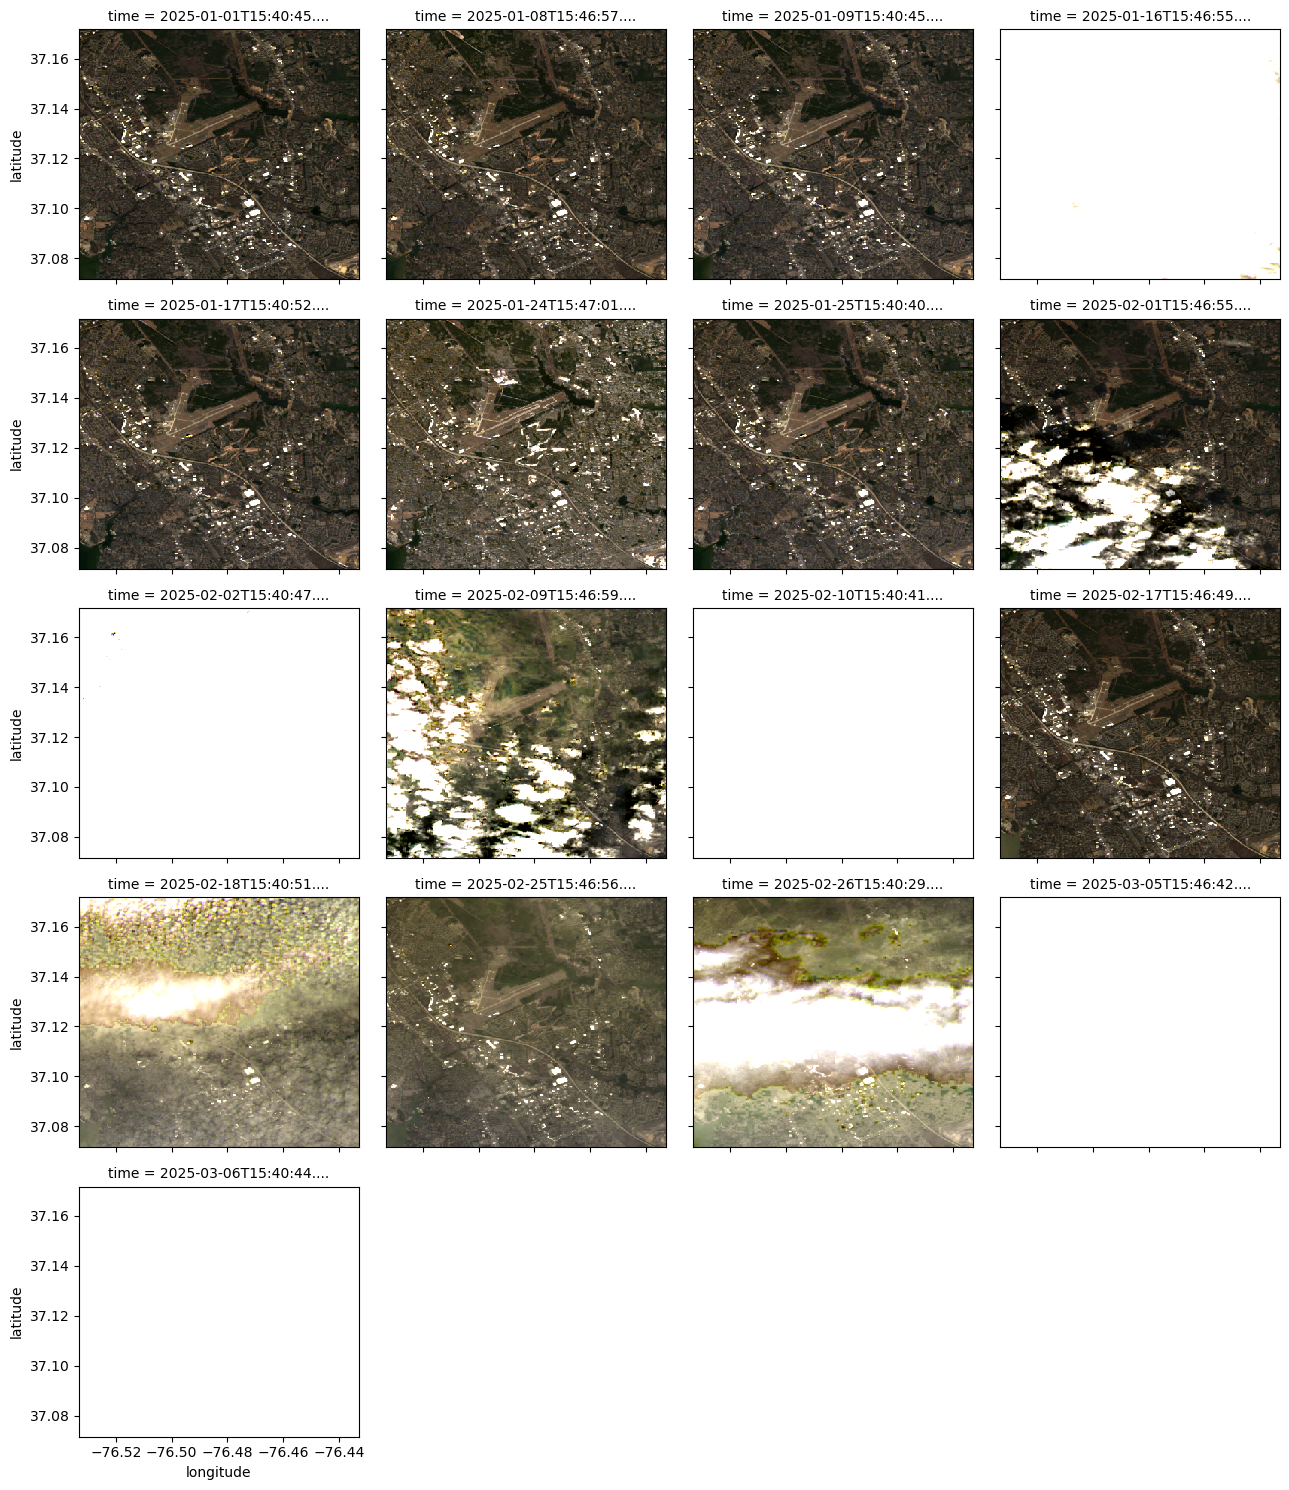

In [10]:
plot_xx = xx[["red","green","blue"]].to_array()
plot_xx.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=0.3)
plt.show()

In [11]:
# Select a time slice to view a simple RGB image and the cloud mask
# See the XARRAY dimensions above for the number of time slices (starts at 0)

time_slice = 7

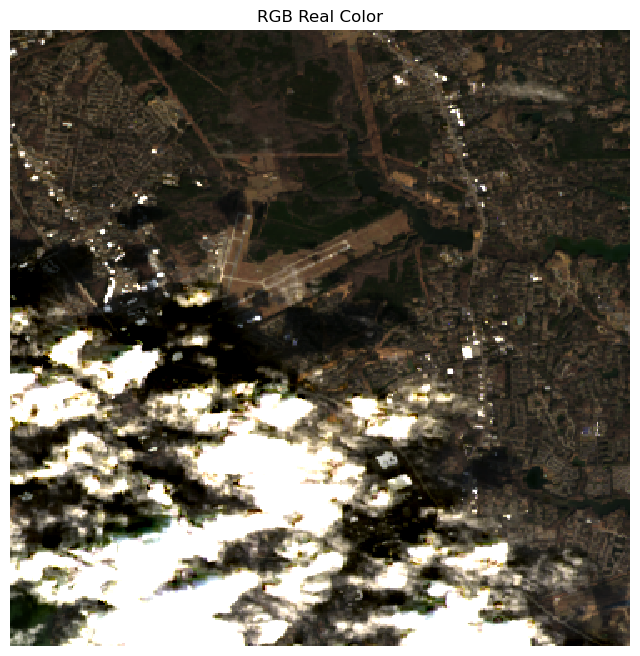

In [12]:
# Plot and RGB Real Color Image for a single date
fig, ax = plt.subplots(figsize=(8, 8))
xx.isel(time=time_slice)[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=0.3)
ax.set_title("RGB Real Color")
ax.axis('off')
plt.show()

### Apply Cloud Filtering and Masking

Cloud masking for Landsat Collection-2 Level-2 data can be complicated. The <b>"qa_pixel"</b> band is used to assess each pixel and determine its cloud or water classification. The code below is credited to Mauricio Cordiero. See his webpage [HERE](https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1619_Landsat-8-9-C2-L2-ScienceProductGuide-v4.pdf) for a more detailed explanation of the process. Also, you can visit the Landsat-8 Collection-2 Level-2 Product Guide [HERE](https://www.usgs.gov/media/files/landsat-8-9-collection-2-level-2-science-product-guide) for more details about the cloud mask values. In the end, we are searching for clouds, cloud shadows, and water to create a mask for any given region. This will allow us to extract the "clear" pixels to assess the vegetation state. 

In [13]:
# To mask the pixels and find clouds or water, it is best to use the bit values of the 16-bit qa_pixel flag
# See the website above for a nice explanation of the process

bit_flags = {
            'fill': 1<<0,
            'dilated_cloud': 1<<1,
            'cirrus': 1<<2, 
            'cloud': 1<<3,
            'shadow': 1<<4, 
            'snow': 1<<5, 
            'clear': 1<<6,
            'water': 1<<7
}

In [14]:
# Create a function that will mask pixels with a given type

def get_mask(mask, flags_list):
    
    # Create the result mask filled with zeros and the same shape as the mask
    final_mask = np.zeros_like(mask)
    
    # Loop through the flags  
    for flag in flags_list:
        
        # get the mask for each flag
        flag_mask = np.bitwise_and(mask, bit_flags[flag])
        
        # add it to the final flag
        final_mask = final_mask | flag_mask
    
    return final_mask > 0

In [15]:
# Pick a single time slice to view a mask with clouds and water
sample_xx = xx.isel(time=time_slice)

In [16]:
# Find the pixels that are no data (fill), clouds, cloud shadows, or water
my_mask = get_mask(sample_xx['qa_pixel'], ['fill', 'dilated_cloud', 'cirrus', 'cloud', 'shadow', 'water'])

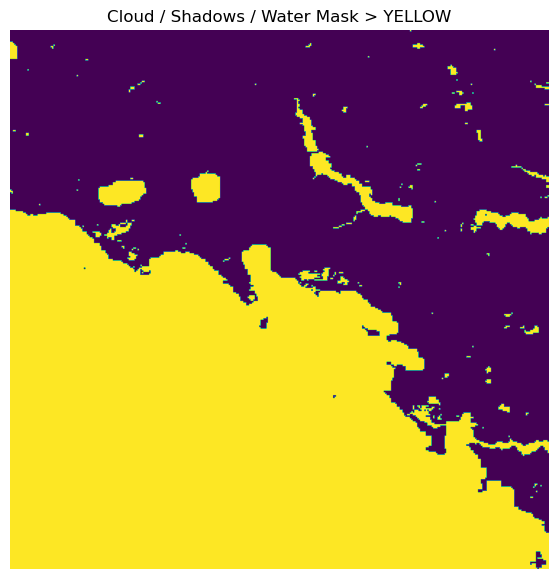

In [17]:
# Show only the mask (Yellow) with valid data in Purple
plt.figure(figsize=(7,7))
plt.imshow(my_mask)
plt.title("Cloud / Shadows / Water Mask > YELLOW")
plt.axis('off')
plt.show()

In [18]:
# Create an RGB function that will display the mask over the background RGB image

def plot_masked_rgb(red, green, blue, mask, color_mask=(1, 0, 0), transparency=0.5, brightness=2):
    
    # to improve our visualization, we will increase the brightness of our values
    red = red / red.max() * brightness
    green = green / green.max() * brightness
    blue = blue / blue.max() * brightness
    
    red = np.where(mask==True, red*transparency+color_mask[0]*(1-transparency), red)
    green = np.where(mask==True, green*transparency+color_mask[1]*(1-transparency), green)
    blue = np.where(mask==True, blue*transparency+color_mask[2]*(1-transparency), blue)
    
    rgb = np.stack([red, green, blue], axis=2)
    
    return rgb

In [19]:
rgb = plot_masked_rgb(sample_xx['red'], sample_xx['green'], sample_xx['blue'], my_mask, color_mask=(1, 0, 1), transparency=0.2, brightness=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2022576294890365..1.6734661808467801].


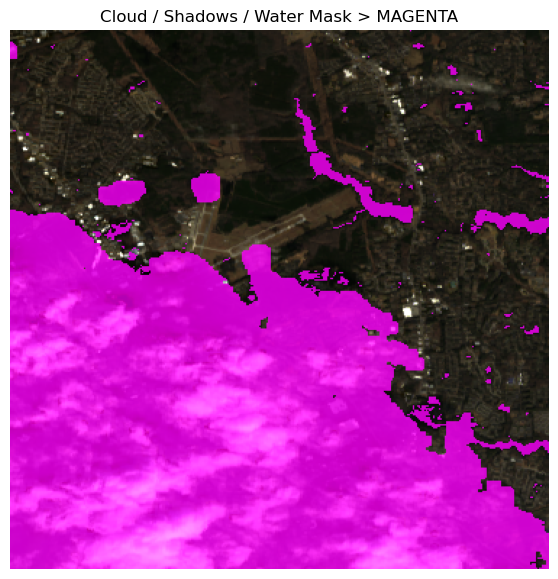

In [ ]:
# This is a nice image that shows the clouds and water pixels (Purple) among clear land pixels
#
# NOTE: You may see a "Clipping input data" warning below. This is expected behavior.
# Landsat reflectance values can fall outside the [0,1] range due to:
#   - Atmospheric correction offsets (can produce negative values)
#   - Brightness enhancement for visualization (can produce values > 1)
# Matplotlib automatically clips these to [0,1] for display:
#   - Values < 0 → become 0 (black)
#   - Values > 1 → become 1 (saturated/white)
# The image renders correctly.

plt.figure(figsize=(7,7))
plt.imshow(rgb)
plt.title("Cloud / Shadows / Water Mask > MAGENTA")
plt.axis('off')
plt.show()

### Normalized Difference Vegetation Index (NDVI)

The <b>Normalized Difference Vegetation Index (NDVI)</b> is used to measure the "greenness" of vegetation and has a range of 0.0 to 1.0. Low values (0.0 to 0.25) reflect a lack of vegetation (bare soil, water), middle values (0.25 to 0.6) reflect crops in their growing state, and high values (0.6 to 1.0) reflect crops at their peak vegetation state. The equation uses two spectral bands where: <b>NDVI = (NIR-Red) / (NIR+Red).
    
The NDVI plot below shows all (unfiltered) pixels (BLUE) and filtered pixels (GREEN). In cases where the filtered data is entirely masked out, it is possible there are no available "clean" pixels to calculate NDVI. This is why there are sometimes "gaps" in the filtered dataset (GREEN) and the line has "gaps". At times when the filtered and unfiltered NDVI values are similar, this suggests low cloud volume in the sample. At times where the filtered and unfiltered NDVI values are very different, this suggests high cloud volume in the sample which tends to adversely lower NDVI. For these reasons, it is important to filter clouds out of the data before calculating NDVI for a given region coincident with an agriculture plot. This will yield the most accurate phenology results.

In [21]:
# Calculate the mask for the entire xarray (all time slices)
full_mask = get_mask(xx['qa_pixel'], ['fill', 'dilated_cloud', 'cirrus', 'cloud', 'shadow', 'water'])

In [22]:
# Create a "clean" dataset with the mask applied 
cleaned_data = xx.where(~full_mask)

In [23]:
# Calculate the mean of the data across the sample region and then NDVI
# Perform this calculation for the unfiltered and cloud-filtered (clean) datasets
mean_unfiltered = xx.mean(dim=['longitude','latitude']).compute()
ndvi_mean = (mean_unfiltered.nir08-mean_unfiltered.red)/(mean_unfiltered.nir08+mean_unfiltered.red)
mean_clean = cleaned_data.mean(dim=['longitude','latitude']).compute()
ndvi_mean_clean = (mean_clean.nir08-mean_clean.red)/(mean_clean.nir08+mean_clean.red)

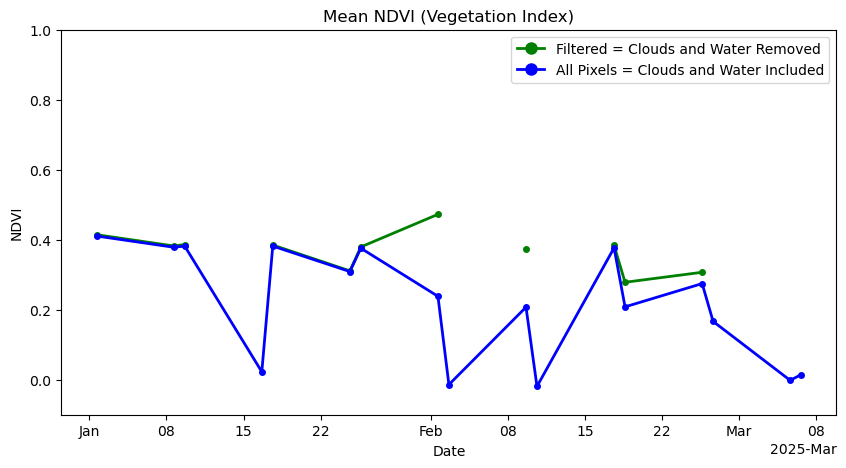

In [24]:
fig = plt.figure(figsize=(10, 5))
ndvi_mean_clean.plot(color='green',marker='o',markersize=4,linewidth=2, label="Filtered = Clouds and Water Removed")
ndvi_mean.plot(color='blue',marker='o',markersize=4,linewidth=2, label="All Pixels = Clouds and Water Included")
plt.title("Mean NDVI (Vegetation Index)")
plt.xlabel("Date")
plt.ylabel("NDVI")
plt.ylim(-0.1,1.0)
plt.legend(loc="upper right", markerscale=2., scatterpoints=1, fontsize=10)
plt.show()

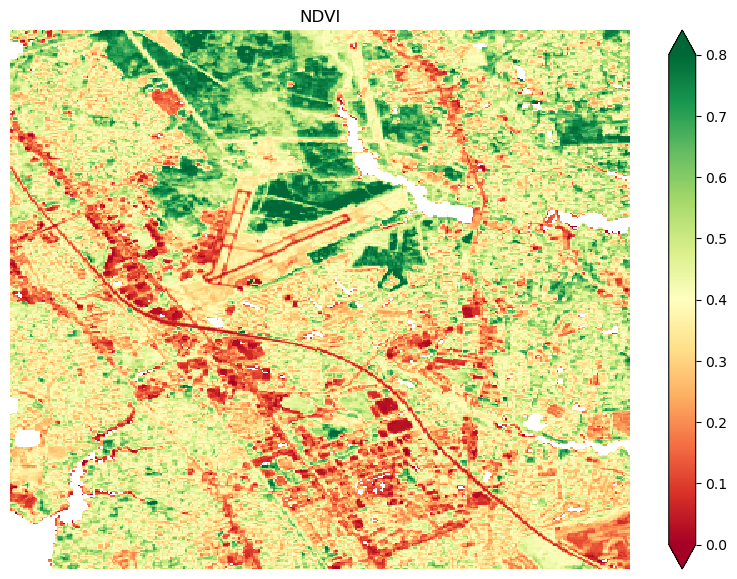

In [25]:
# Plot an NDVI image for a single date with few clouds

fig = plt.figure(figsize=(10, 7))
ndvi_image = (cleaned_data.nir08-cleaned_data.red)/(cleaned_data.nir08+cleaned_data.red)
ndvi_image.isel(time=6).plot(vmin=0.0, vmax=0.8, cmap="RdYlGn")
plt.title("NDVI")
plt.axis('off')
plt.show()

## Conclusion
Congratulations, you have successfully deployed a satellite imagery data pipeline in a Snowflake Notebook. 

To take it a step further, go to the left-sidebar navigation and upload 2 additional files: 

1. Jupyter Notebook titled "Landsat_Demo_Snowflake.ipynb" 
1. CSV file titled "water_quality_training_dataset_100.csv"

Use these files to retrieve Landsat data from 100 GPS locations, then draw a buffer around these coordinates, and analyze data at these locations.